Cristel Irwin

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import Series
from statsmodels.tsa.stattools import adfuller
from numpy import log
from pandas import datetime
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

C:\Users\s_cri\AppData\Local\Temp/ipykernel_31392/3464462392.py:11: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


## 1 Assume the 'robberies.csv' dataset from Brownlee Chapter 30:

In [2]:
robberies = pd.read_csv('robberies.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
robberies

Month
1966-01-01     41
1966-02-01     39
1966-03-01     50
1966-04-01     40
1966-05-01     43
             ... 
1975-06-01    316
1975-07-01    398
1975-08-01    394
1975-09-01    431
1975-10-01    431
Name: Robberies, Length: 118, dtype: int64

## 1.a Perform a Dickey-Fuller test on the series.

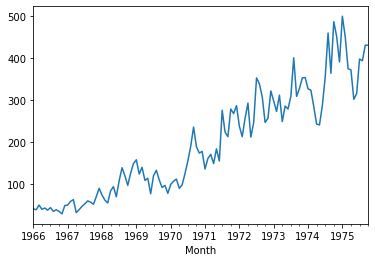

In [3]:
#Initial look at robberies.csv data shows that it is non-stationary.

robberies.plot()
pyplot.show()

ADF Observation (robberies):
The ADF test statistic is positive at 1.00, meaning that it is less likely to reject the null hypothesis that the data is non-stationary. When comparing the ADF to the negative critical values, it seems that we should fail to reject the null hypothesis that the time series is non-stationary and has a time-dependent structure. The p-value of 0.0.99 is greater than 0.05. Therefore, we fail to reject the null hypothesis (H0). The data has a unit root and is non-stationary as we can already see from the plot above. 

In [4]:
#Dickey-Fuller

X = robberies.values
X = X.astype('float32')

result = adfuller(X)

print('ADF Statistic: %f' % result[0])
print('\np-value: %f' % result[1])
print('\nCritical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 1.001102

p-value: 0.994278

Critical Values:
	1%: -3.494
	5%: -2.889
	10%: -2.582


## 1.b Detrend the series with a polynomial fit

In [5]:
from numpy import polyfit

#Source: Brownlee 14.4 pg.127-130 

X = [i%365 for i in range(0, len(robberies))]
y = robberies.values
degree = 4
coef = polyfit(X, y, degree)
print('Coefficients: %s' % coef)

Coefficients: [-3.62302432e-06  5.89202213e-04 -3.94588740e-03  1.36679440e+00
  3.40030361e+01]


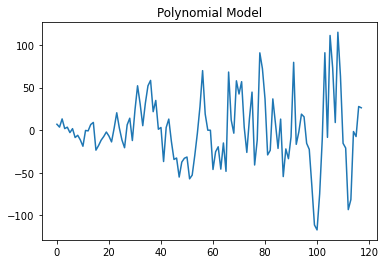

In [6]:
curve = list()

for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)

values = robberies.values
diff = list()


for i in range(len(values)):
    value = values[i] - curve[i]
    diff.append(value)

pyplot.plot(diff)
plt.title("Polynomial Model")
pyplot.show()

## 1.c  At what polynomial order does the detrended series become stationary?

first order

## 1.d Perform differencing on the original series to induce stationarity

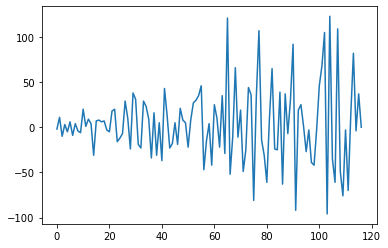

In [7]:
## Source: Brownlee 13.3 pg.114

def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

X = robberies.values

diff = list()
for i in range(1, len(X)):
    value = X[i] - X[i - 1]
    diff.append(value)
pyplot.plot(diff)
pyplot.show()

## 1.e At what order of differencing does the series become stationary?

third order

## 2 Assume the 'champagne.csv' dataset from Brownlee Chapter 32:

In [8]:
champagne = pd.read_csv('champagne.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
champagne

Month
1964-01-01    2815
1964-02-01    2672
1964-03-01    2755
1964-04-01    2721
1964-05-01    2946
              ... 
1972-05-01    4618
1972-06-01    5312
1972-07-01    4298
1972-08-01    1413
1972-09-01    5877
Name: Sales, Length: 105, dtype: int64

## 1.a Perform a Dickey-Fuller test on the series.

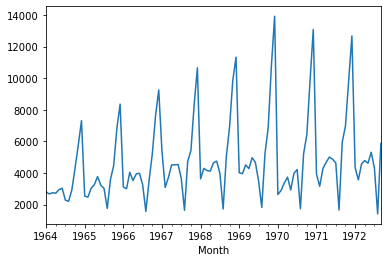

In [9]:
champagne.plot()
pyplot.show()

In [10]:
X2 = champagne.values

result = adfuller(X2)

print('ADF Statistic: %f' % result[0])
print('\np-value: %f' % result[1])
print('\nCritical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.833593

p-value: 0.363916

Critical Values:
	1%: -3.503
	5%: -2.893
	10%: -2.584


In [11]:
from pmdarima.arima import ADFTest

adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(champagne)

(0.01, False)

## ADF results (champagne dataset):
   
    The champagne data is non-stationary.

## 2.b Perform seasonal differencing to eliminate seasonality

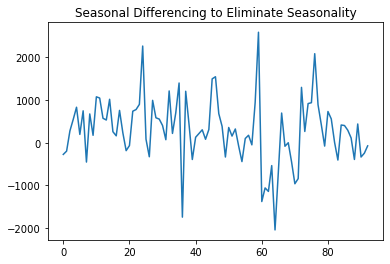

In [12]:
#Source: Brownlee 14.3 pg.124-125

resample = champagne.resample('M')
monthly_mean = resample.mean()

diff = list()
months = 12

for i in range(months, len(monthly_mean)):
    value = monthly_mean[i] - monthly_mean[i - months]
    diff.append(value)
    
pyplot.plot(diff)
plt.title("Seasonal Differencing to Eliminate Seasonality")
pyplot.show()

ADF Statistic: -7.626619

p-value: 0.000000

Critical Values:
	1%: -3.504
	5%: -2.894
	10%: -2.584


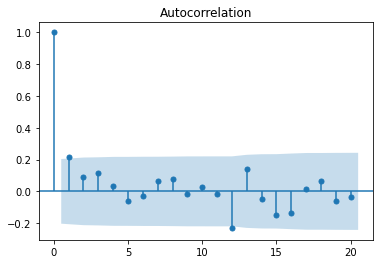

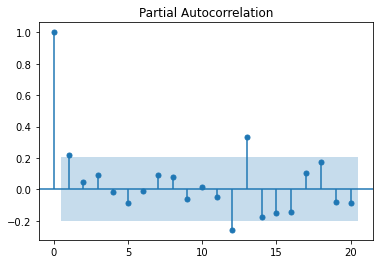

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#ADF on deasonalized data

result_sd = adfuller(diff)
print('ADF Statistic: %f' % result_sd[0])
print('\np-value: %f' % result_sd[1])
print('\nCritical Values:')

for key, value in result_sd[4].items():
    print('\t%s: %.3f' % (key, value))
    
plot_acf(diff, lags=20)
pyplot.show()
plot_pacf(diff, lags=20)
pyplot.show()

## 2.c Is the resulting series stationary?

Yes, the result is stationary

## 2.d Perform a seasonal decomposition on the original series and plot the results

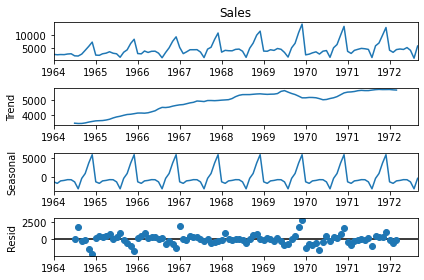

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

#Source Brownlee 12.4 pg.107

result = seasonal_decompose(champagne, model='additive')

result.plot()
pyplot.show()

## 2.e Plot a 1 year period (Jan-Dec) for only the seasonal component

In [15]:
#Source: Brownlee 14.4 pg. 14-20

X2 = [i%365 for i in range(0, len(champagne))] #365 for 1 year
y = champagne.values
degree = 4
coef = polyfit(X2, y, degree)
print('Coefficients:\n %s' % coef)

Coefficients:
 [-1.78647317e-04  3.52025723e-02 -2.65928209e+00  1.17201345e+02
  2.54585256e+03]


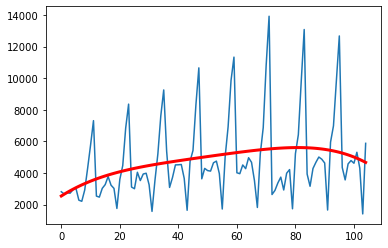

In [16]:
curve = list()

for i in range(len(X2)):
    value = coef[-1]
    for d in range(degree):
        value += X2[i]**(degree-d) * coef[d]
    curve.append(value)
 
pyplot.plot(champagne.values)
pyplot.plot(curve, color='red', linewidth=3)
pyplot.show()

## 3 Assume the 'series.csv' dataset:

In [17]:
series = pd.read_csv('series.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
series.head()

0    0.000000
1    0.000000
2    0.000000
3   -0.794418
4    0.892467
Name: 0, dtype: float64

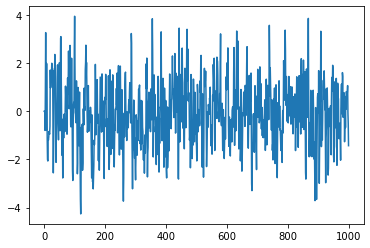

In [18]:
#Dataset is stationary

series.plot()
pyplot.show()

## 3.a Using ACF & PACF plots, estimate the ARMA(p,q) order

In [19]:
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(series)

(0.01, False)

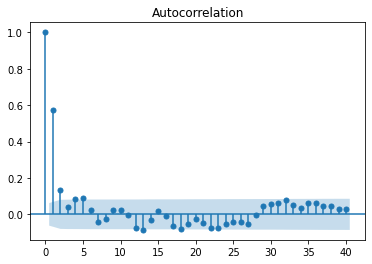

In [20]:
#ACF
#Not autoregressive because model does not decay over time, it becomes positive

from statsmodels.graphics.tsaplots import plot_acf

plot_acf(series, lags=40)
pyplot.show()

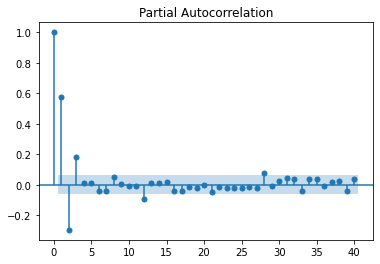

In [21]:
#PACF
#Strong lags at zero, one, two(negative),and three

from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(series, lags=40)
pyplot.show()

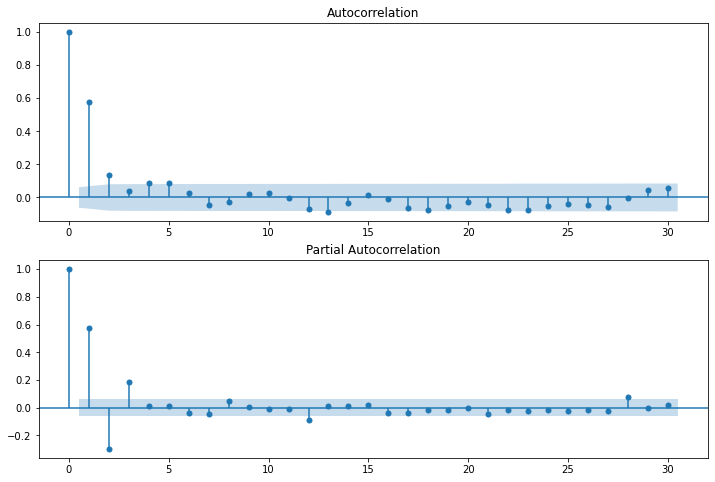

In [22]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(series, lags=30, ax=ax1)  
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(series, lags=30, ax=ax2)

Estimate: Estimate the AR model with the lag from the PACF which leads me to conclude that p = 3. 

***How should I have written this?

In [23]:
from statsmodels.tsa.arima.model import ARIMA

arma_mod20 = ARIMA(series, order=(1, 1, 1)).fit()
print(arma_mod20.params)

ar.L1     0.576509
ma.L1    -0.999977
sigma2    1.169922
dtype: float64


## 3.b Going with your answer for p, calculate the a1 - ap coefficients using the Yule-Walker equations

In [24]:
import statsmodels.api as sm
from statsmodels.datasets.sunspots import load

rho, sigma = sm.regression.yule_walker(series, order=3, method="mle")

print(rho)
print(sigma)

[ 0.79829734 -0.430456    0.18130054]
1.0159736397298893


## 4. The sunspot cycle is estimated at 11 years. Based on the ACF of the "Monthly Sunspots" dataset, what is the sunspot cycle to the nearest month?

In [25]:
sunspots = pd.read_csv('sunspots.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
sunspots.tail()

Month
1983-08-01    71.8
1983-09-01    50.3
1983-10-01    55.8
1983-11-01    33.3
1983-12-01    33.4
Name: Sunspots, dtype: float64

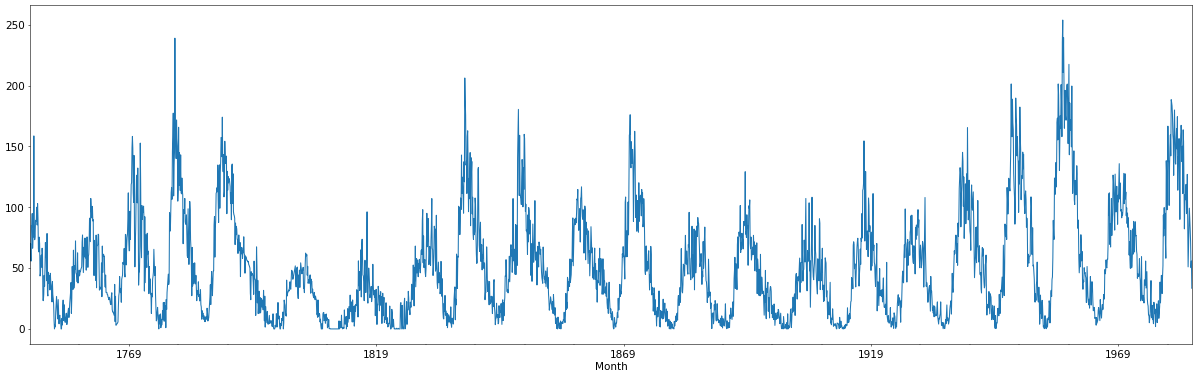

In [26]:
from matplotlib.pyplot import figure

figure(figsize=(30, 9), dpi=50)
plt.rcParams.update({'font.size': 15})
sunspots.plot()
pyplot.show()

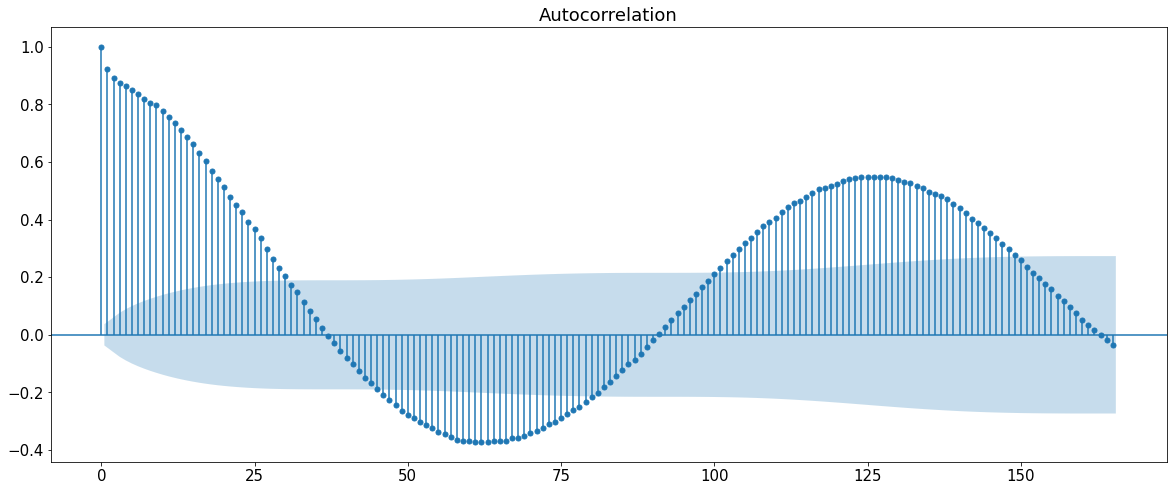

In [27]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(111)
fig = sm.graphics.tsa.plot_acf(sunspots, lags=165, ax=ax1)

## November